In [6]:
from PIL import Image, ImageOps
from fastcore.xtras import Path

import matplotlib.pyplot as plt
import numpy as np
import dlib
import cv2
import torch

In [3]:
def image_grid(imgs, rows, cols):
    #assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [4]:
img_test_path=Path('/Users/sbrewer/Documents/LDM')
img_test_path.exists()

True

(512, 512) (512, 512)


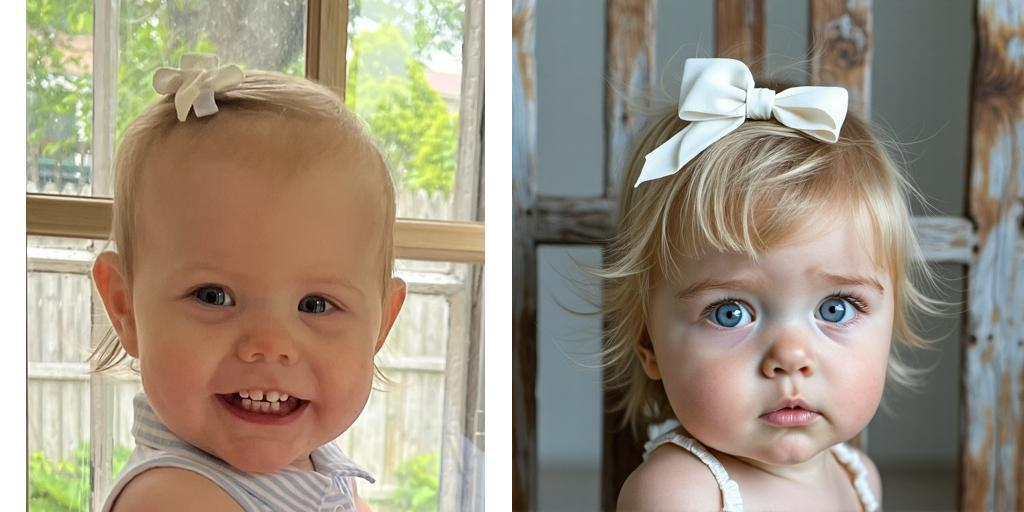

In [5]:
img1=Image.open(img_test_path/'V4_sz.jpeg')

img2=Image.open(img_test_path/'AI-V4.jpeg')
print(img1.size, img2.size)
image_grid([img1, img2], 1, 2)

In [7]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

'mps'

In [31]:
gray1=np.array(img1.convert('L'))
gray2=np.array(img2.convert('L'))

In [13]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [33]:
# Detect faces
faces1 = detector(gray1)
faces2 = detector(gray2)

In [34]:
img_bgr1=cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR)
img_bgr2=cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR)

In [35]:
for face in faces1:
    # Get the 68 landmarks
    shape = predictor(gray1, face)
    landmarks1 = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    
    # Draw them on the image
    for (x, y) in landmarks1:
        cv2.circle(img_bgr1, (x, y), 2, (0, 255, 0), -1)

for face in faces2:
    # Get the 68 landmarks
    shape = predictor(gray2, face)
    landmarks2 = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    
    # Draw them on the image
    for (x, y) in landmarks2:
        cv2.circle(img_bgr2, (x, y), 2, (0, 255, 0), -1)

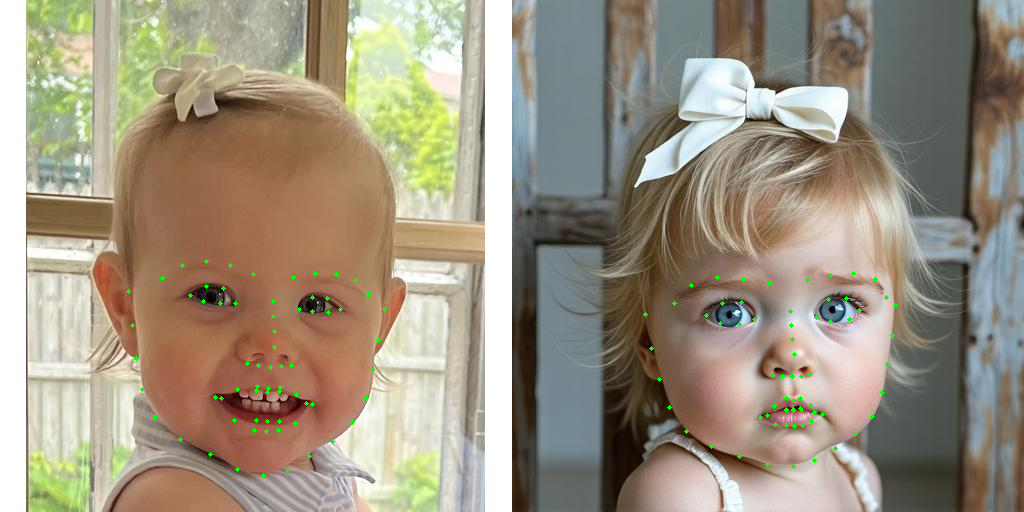

In [36]:
image_grid([Image.fromarray(cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB)), 
            Image.fromarray(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))], 1, 2)


In [39]:
# Create SIFT extractor
sift = cv2.SIFT_create()

# Convert (x, y) tuples to cv2.KeyPoint
cv2_keypoints1 = [cv2.KeyPoint(x=float(x), y=float(y), size=1) for (x, y) in landmarks1]
cv2_keypoints2 = [cv2.KeyPoint(x=float(x), y=float(y), size=1) for (x, y) in landmarks2]

# Compute descriptors (keypoints may be updated with scale/orientation info)
kpt1, desc1 = sift.compute(gray1, cv2_keypoints1)
kpt2, desc2 = sift.compute(gray2, cv2_keypoints2)

In [44]:
kpt1[0].pt==landmarks1[0]

True

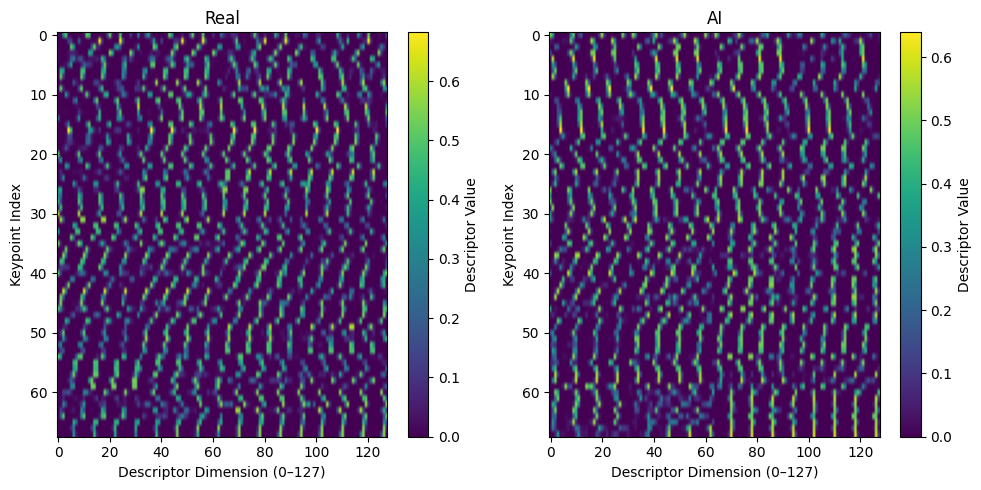

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(desc1/255, aspect='auto', cmap='viridis')
plt.title("Real")
plt.colorbar(label='Descriptor Value')
plt.xlabel('Descriptor Dimension (0–127)')
plt.ylabel('Keypoint Index')

plt.subplot(1, 2, 2)
plt.imshow(desc2/255, aspect='auto', cmap='viridis')
plt.title("AI")
plt.colorbar(label='Descriptor Value')
plt.xlabel('Descriptor Dimension (0–127)')
plt.ylabel('Keypoint Index')
plt.tight_layout()
plt.show()

In [48]:
X=np.concatenate([desc1,desc2])/255
y=[0]*len(desc1)+[1]*len(desc2)

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2)

# Define and train model
clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=500, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.44      0.47        16
           1       0.36      0.42      0.38        12

    accuracy                           0.43        28
   macro avg       0.43      0.43      0.43        28
weighted avg       0.44      0.43      0.43        28

